# ELE2769 -  Remote Sensing Image Analysis - Assignment 1
## Image Correction and Registration

#### Getting Things Set-up:

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import sklearn.decomposition
import skimage.filters
from sklearn.decomposition import PCA

In [2]:
%%capture
cd IKONOS_SJC/

In [42]:
save_figs = True

Defining Some Functions

In [3]:
def norm(im_in, scale=255):
    out_type = im_in.dtype
    im_out = np.zeros(im_in.shape).astype(out_type)
    
    if len(im_in.shape) == 3:
        for i in range(im_in.shape[2]):
            chan_min = np.amin(im_in[:,:,i])
            chan_max = np.amax(im_in[:,:,i])
            im_out[:,:,i] = (im_in[:,:,i] - chan_min)/(chan_max-chan_min)
    
    if len(im_in.shape) == 2:
        chan_min = np.amin(im_in)
        chan_max = np.amax(im_in)
        im_out = (im_in - chan_min)/(chan_max-chan_min)
    
    return im_out*scale

In [4]:
def multichannel(chn1, chn2, chn3):
    '''This function takes in 3 same sized channels and puts them together in a single image'''
    if chn1.shape == chn2.shape == chn3.shape:
        im_out = np.zeros(chn1.shape + (3,))
        im_out[:,:,0] = chn1
        im_out[:,:,1] = chn2
        im_out[:,:,2] = chn3
        
        return im_out
    
    else:
        print('The Channels Must be The Same Size')

In [18]:
def pansharpening_HSV(im_in, im_pan):
    
    if im_in.shape[:2] == im_pan.shape:
        im_in = im_in*255
        im_pan = im_pan*255
        img_HSV_in = cv2.cvtColor(im_in.astype('uint8'), cv2.COLOR_RGB2HSV)
        img_HSV_in[:,:,2] = im_pan
        img_HSV_out = cv2.cvtColor(img_HSV_in.astype('uint8'), cv2.COLOR_HSV2RGB)

        return img_HSV_out
    
    else:
        print('The X Y Sizes Should be the Same')

In [21]:
def pansharpening_HSV_norm(im_in, im_pan, scale=255):
    
    if im_in.shape[:2] == im_pan.shape:
        im_in = norm(im_in, scale)
        im_pan = norm(im_pan, scale)
        img_HSV_in = cv2.cvtColor(im_in.astype('uint8'), cv2.COLOR_RGB2HSV)
        img_HSV_in[:,:,2] = im_pan
        img_HSV_out = cv2.cvtColor(img_HSV_in.astype('uint8'), cv2.COLOR_HSV2RGB)

        return img_HSV_out
    
    else:
        print('The X Y Sizes Should be the Same')

In [7]:
def pansharpening_PCA(im_in, im_pan):
    
    if im_in.shape[:2] == im_pan.shape:
        new_shape = (im_in.shape[0]*im_in.shape[1],3)
        pan_newshape = im_pan.reshape(new_shape[0])
        
        pca = PCA(n_components=2)
        pcomponets = pca.fit_transform(im_in.reshape(new_shape))
        pcomponets[:,0] = pan_newshape
        
        im_out = pca.inverse_transform(pcomponets)
        im_out = im_out.reshape(im_in.shape)

        return im_out
    
    else:
        print('The X Y Sizes Should be the Same')

In [8]:
def pansharpening_PCA_norm(im_in, im_pan, scale=1):
    im_in = norm(im_in, scale = scale)
    im_pan = norm(im_pan, scale = scale)
    
    if im_in.shape[:2] == im_pan.shape:
        new_shape = (im_in.shape[0]*im_in.shape[1],3)
        pan_newshape = im_pan.reshape(new_shape[0])
        
        pca = PCA(n_components=2)
        pcomponets = pca.fit_transform(im_in.reshape(new_shape))
        pcomponets[:,0] = pan_newshape
        
        im_out = pca.inverse_transform(pcomponets)
        im_out = im_out.reshape(im_in.shape)

        return im_out
    
    else:
        print('The X Y Sizes Should be the Same')

Loading the data

In [9]:
img_preffix = 'img_raw_'
img_raw = ['red', 'grn', 'blu', 'nir', 'pan']
for i in range(len(img_raw)):
    var = img_preffix + img_raw[i]
    vars()[var] = plt.imread('sjc_'+img_raw[i]+'.png')

Checking if everything loaded up properly

<IPython.core.display.Javascript object>


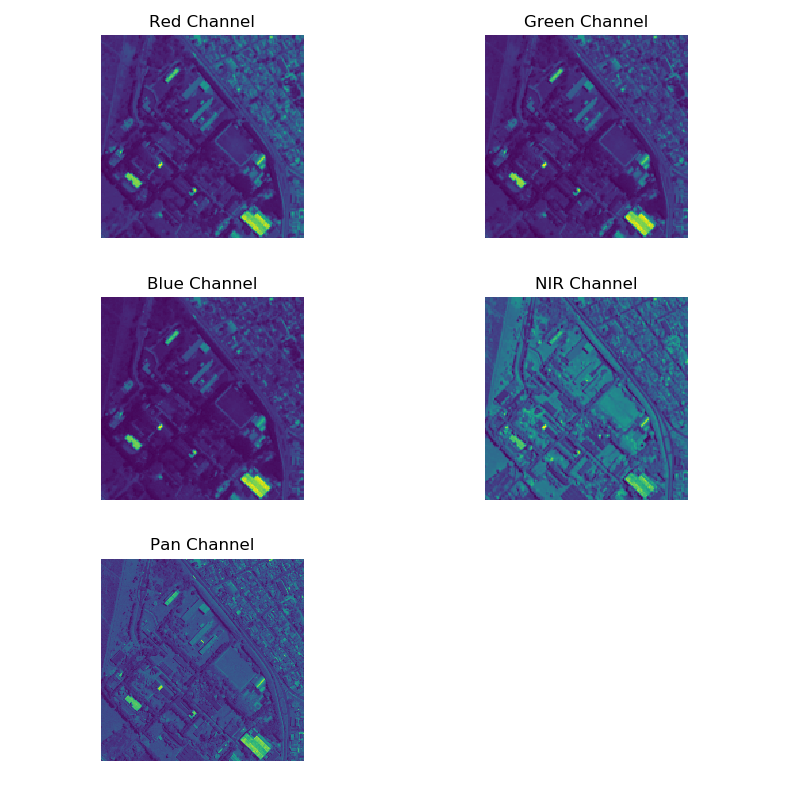

In [52]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_raw_red)
ax1.set_axis_off()
ax1.set_title('Red Channel')

ax2.imshow(img_raw_grn)
ax2.set_axis_off()
ax2.set_title('Green Channel')

ax3.imshow(img_raw_blu)
ax3.set_axis_off()
ax3.set_title('Blue Channel')

ax4.imshow(img_raw_nir)
ax4.set_axis_off()
ax4.set_title('NIR Channel')

ax5.imshow(img_raw_pan)
ax5.set_axis_off()
ax5.set_title('Pan Channel')

ax6.axis('off')
fig.tight_layout()


if save_figs == True:
    plt.savefig('raw_channels.tiff', dpi=300)

Putting the Channels together to into 2 pictures (R,G,B) and (NIR,R,G)

In [11]:
img_rgb = multichannel(img_raw_red,img_raw_grn,img_raw_blu)
img_nrg = multichannel(img_raw_nir,img_raw_red,img_raw_blu)

Checking if everything works

<IPython.core.display.Javascript object>


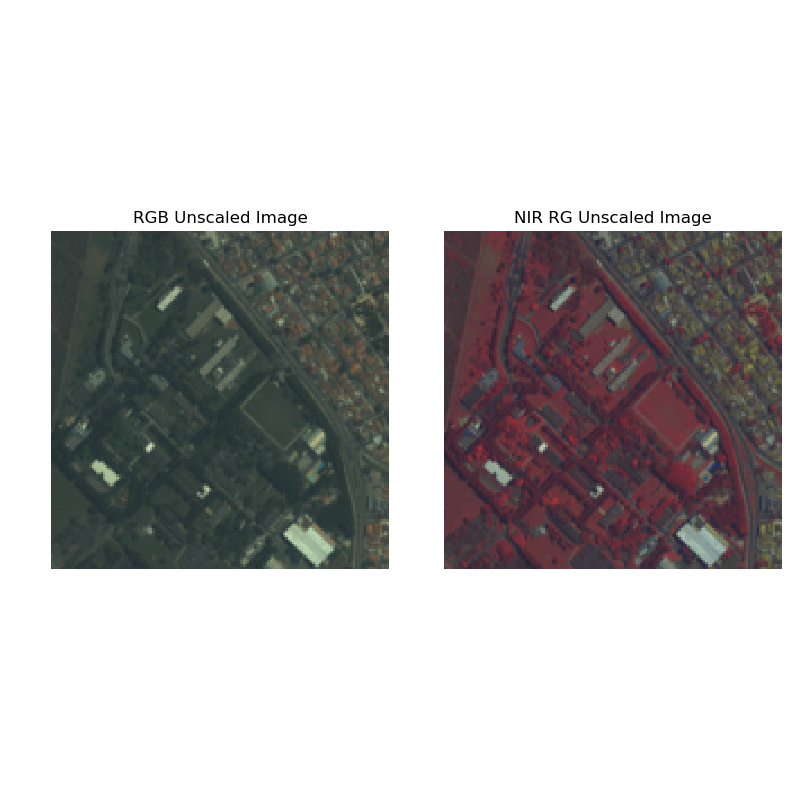

In [53]:
fig, axis = plt.subplots(1,2, figsize=(8,8))

axis[0].imshow(img_rgb)
axis[0].set_title('RGB Unscaled Image')
axis[0].set_axis_off()
axis[1].imshow(img_nrg)
axis[1].set_axis_off()
axis[1].set_title('NIR RG Unscaled Image')
fig.tight_layout()

if save_figs == True:
    plt.savefig('channel_composition.tiff', dpi=300)

Resizing the images to the same size as PAN using 3 different interpolation methods: nearest neighborhood, bilinear, bicubic

In [13]:
img_rgb_resize_nn = cv2.resize((img_rgb).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_NEAREST)
img_rgb_resize_bl = cv2.resize((img_rgb).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_LINEAR)
img_rgb_resize_bc = cv2.resize((img_rgb).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_CUBIC)

In [14]:
img_nrg_resize_nn = cv2.resize((img_nrg).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_NEAREST)
img_nrg_resize_bl = cv2.resize((img_nrg).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_LINEAR)
img_nrg_resize_bc = cv2.resize((img_nrg).astype('float'),img_raw_pan.shape,interpolation = cv2.INTER_CUBIC)

<IPython.core.display.Javascript object>


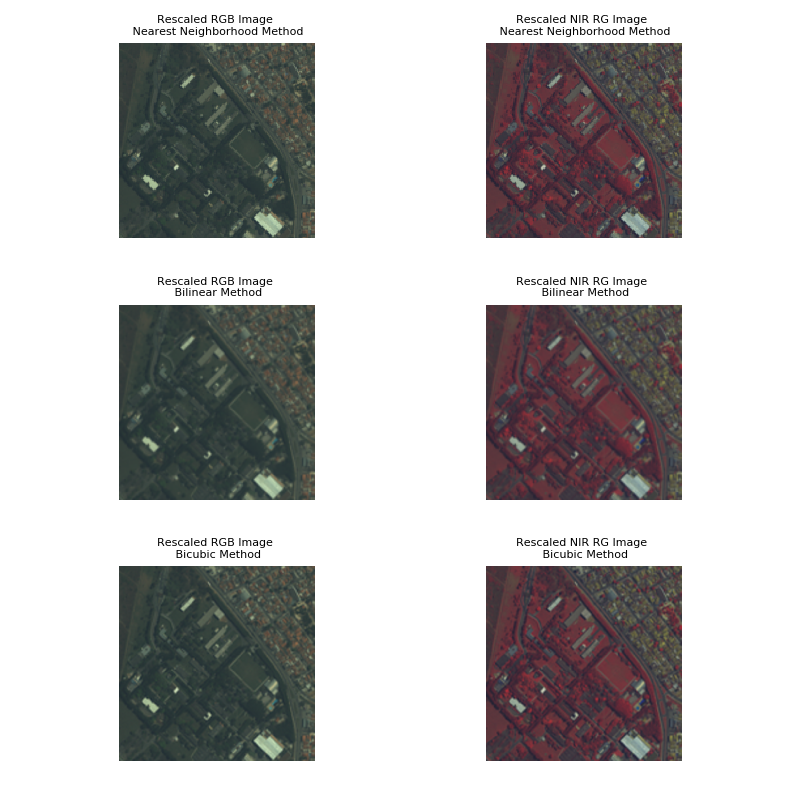

In [54]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_rgb_resize_nn)
ax1.set_axis_off()
ax1.set_title('Rescaled RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_rgb_resize_bl)
ax3.set_axis_off()
ax3.set_title('Rescaled RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_rgb_resize_bc)
ax5.set_axis_off()
ax5.set_title('Rescaled RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_nrg_resize_nn)
ax2.set_axis_off()
ax2.set_title('Rescaled NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_nrg_resize_bl)
ax4.set_axis_off()
ax4.set_title('Rescaled NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_nrg_resize_bc)
ax6.set_axis_off()
ax6.set_title('Rescaled NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()

if save_figs == True:
    plt.savefig('rescale.tiff', dpi=300)

<IPython.core.display.Javascript object>


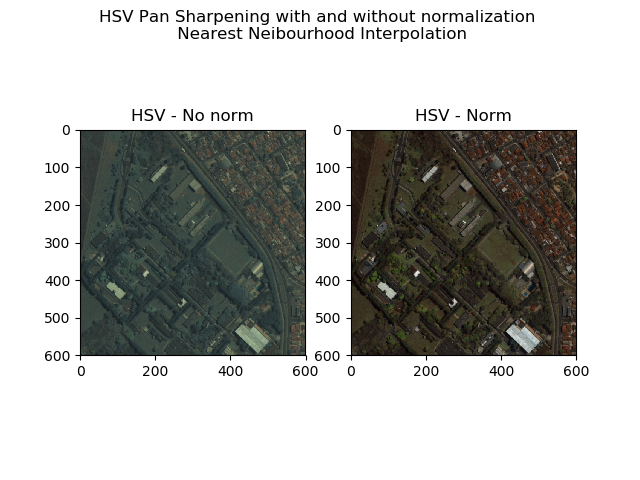

In [55]:
test_no_norm = pansharpening_HSV(img_rgb_resize_nn,img_raw_pan)
test_norm = pansharpening_HSV_norm(img_rgb_resize_nn,img_raw_pan)

fig, axis = plt.subplots(1,2)
axis[0].imshow(test_no_norm)
axis[0].set_title('HSV - No norm')
axis[1].imshow(test_norm)
axis[1].set_title('HSV - Norm')
fig.suptitle('HSV Pan Sharpening with and without normalization \n Nearest Neibourhood Interpolation')

if save_figs == True:
    plt.savefig('hsvnorm.tiff', dpi=300)

In [22]:
img_Pan_rgb_nn = pansharpening_HSV_norm(img_rgb_resize_nn,img_raw_pan)
img_Pan_rgb_bl = pansharpening_HSV_norm(img_rgb_resize_bl,img_raw_pan)
img_Pan_rgb_bc = pansharpening_HSV_norm(img_rgb_resize_bc,img_raw_pan)

In [23]:
img_Pan_nrg_nn = pansharpening_HSV_norm(img_nrg_resize_nn,img_raw_pan)
img_Pan_nrg_bl = pansharpening_HSV_norm(img_nrg_resize_bl,img_raw_pan)
img_Pan_nrg_bc = pansharpening_HSV_norm(img_nrg_resize_bc,img_raw_pan)

<IPython.core.display.Javascript object>


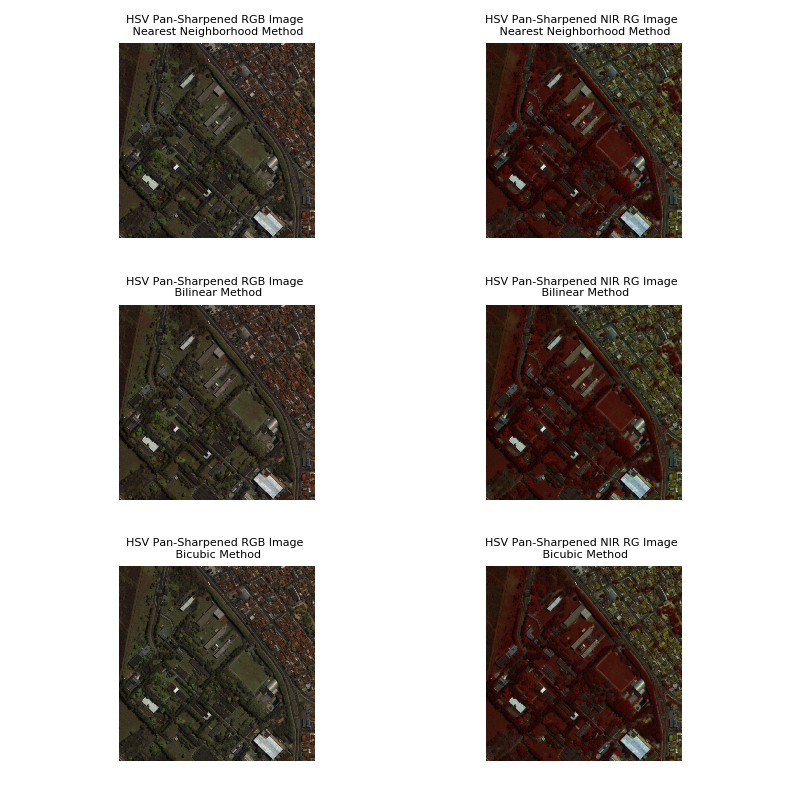

In [56]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_Pan_rgb_nn)
ax1.set_axis_off()
ax1.set_title('HSV Pan-Sharpened RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_Pan_rgb_bl)
ax3.set_axis_off()
ax3.set_title('HSV Pan-Sharpened RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_Pan_rgb_bc)
ax5.set_axis_off()
ax5.set_title('HSV Pan-Sharpened RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_Pan_nrg_nn)
ax2.set_axis_off()
ax2.set_title('HSV Pan-Sharpened NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_Pan_nrg_bl)
ax4.set_axis_off()
ax4.set_title('HSV Pan-Sharpened NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_Pan_nrg_bc)
ax6.set_axis_off()
ax6.set_title('HSV Pan-Sharpened NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()

if save_figs == True:
    plt.savefig('hsi_pansharp.tiff', dpi=300)

<IPython.core.display.Javascript object>


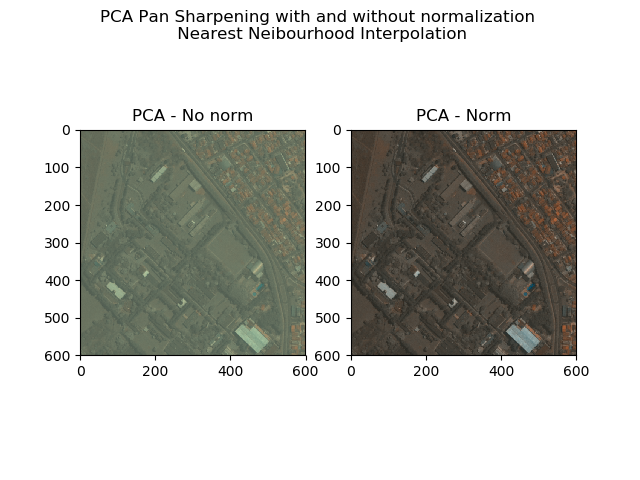

In [65]:
test_no_norm = pansharpening_PCA(img_rgb_resize_nn,img_raw_pan)
test_norm = pansharpening_PCA_norm(img_rgb_resize_nn,img_raw_pan)

fig, axis = plt.subplots(1,2)
axis[0].imshow(test_no_norm)
axis[0].set_title('PCA - No norm')
axis[1].imshow(test_norm)
axis[1].set_title('PCA - Norm')
fig.suptitle('PCA Pan Sharpening with and without normalization \n Nearest Neibourhood Interpolation')

if save_figs == True:
    plt.savefig('pcanorm.tiff', dpi=200)

In [25]:
img_PanPCA_rgb_nn = pansharpening_PCA_norm(img_rgb_resize_nn,img_raw_pan)
img_PanPCA_rgb_bl = pansharpening_PCA_norm(img_rgb_resize_bl,img_raw_pan)
img_PanPCA_rgb_bc = pansharpening_PCA_norm(img_rgb_resize_bc,img_raw_pan)

In [26]:
img_PanPCA_nrg_nn = pansharpening_PCA_norm(img_nrg_resize_nn,img_raw_pan)
img_PanPCA_nrg_bl = pansharpening_PCA_norm(img_nrg_resize_bl,img_raw_pan)
img_PanPCA_nrg_bc = pansharpening_PCA_norm(img_nrg_resize_bc,img_raw_pan)

<IPython.core.display.Javascript object>


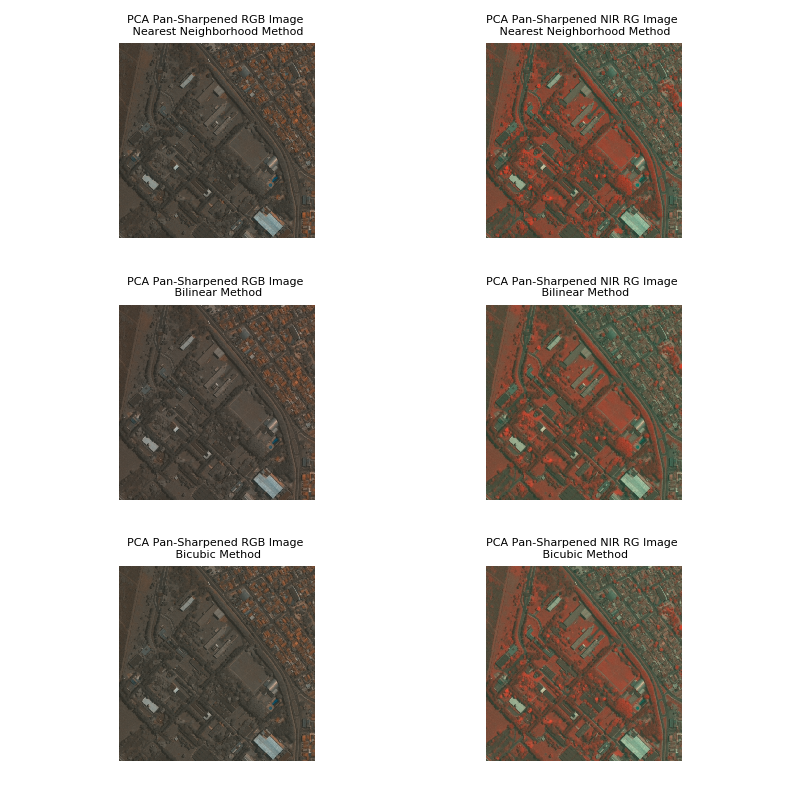

In [67]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize = (8,8))

ax1.imshow(img_PanPCA_rgb_nn)
ax1.set_axis_off()
ax1.set_title('PCA Pan-Sharpened RGB Image \n Nearest Neighborhood Method', fontsize = 8)

ax3.imshow(img_PanPCA_rgb_bl)
ax3.set_axis_off()
ax3.set_title('PCA Pan-Sharpened RGB Image \n Bilinear Method', fontsize = 8)

ax5.imshow(img_PanPCA_rgb_bc)
ax5.set_axis_off()
ax5.set_title('PCA Pan-Sharpened RGB Image \n Bicubic Method', fontsize = 8)

ax2.imshow(img_PanPCA_nrg_nn)
ax2.set_axis_off()
ax2.set_title('PCA Pan-Sharpened NIR RG Image \n Nearest Neighborhood Method', fontsize = 8)

ax4.imshow(img_PanPCA_nrg_bl)
ax4.set_axis_off()
ax4.set_title('PCA Pan-Sharpened NIR RG Image \n Bilinear Method', fontsize = 8)


ax6.imshow(img_PanPCA_nrg_bc)
ax6.set_axis_off()
ax6.set_title('PCA Pan-Sharpened NIR RG Image \n Bicubic Method', fontsize = 8)

fig.tight_layout()

if save_figs == True:
    plt.savefig('pca_pansharp.tiff', dpi=200)

<IPython.core.display.Javascript object>


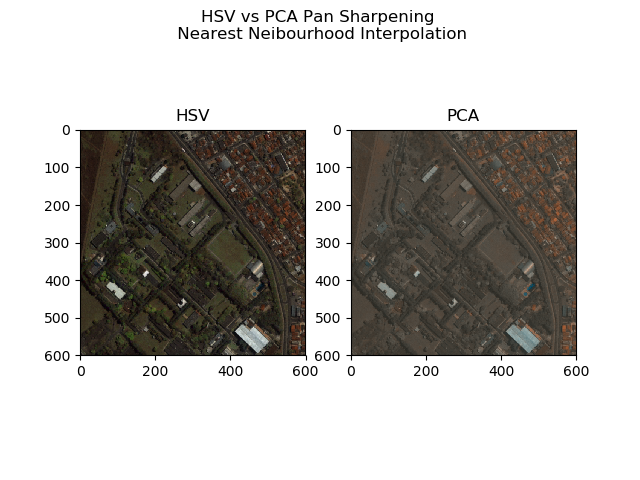

In [69]:
test_no_norm = pansharpening_HSV_norm(img_rgb_resize_nn,img_raw_pan)
test_norm = pansharpening_PCA_norm(img_rgb_resize_nn,img_raw_pan)

fig, axis = plt.subplots(1,2)
axis[0].imshow(test_no_norm)
axis[0].set_title('HSV')
axis[1].imshow(test_norm)
axis[1].set_title('PCA')
fig.suptitle('HSV vs PCA Pan Sharpening \n Nearest Neibourhood Interpolation')

if save_figs == True:
    plt.savefig('pcavshsi.tiff', dpi=200)